OpenCV 15thDec to 2ndJan

notebook runs <6sec

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

%matplotlib inline

## IMAGE PROCESSING METHODS WITH EXAMPLES

Image Proceesing is a process to get useful information from an image. The OpenCV Library is often used for this. Identifying color changes or changes in pixel gradience or identifying contours in an image are some of the useful tools available in OpenCV. 

Here I attempt to cover computer vision methods with examples to seprate foreground from the background for colour and gray images. Using OpenCV, image read in as arrays can be manipulated to get this useful information.

----

### COLOUR IMAGES


For coloured images this can be done by creating an image mask in HSV/HSL for a required range of hue values, for examplle lighter shade of green to darker shade of green, and then using bitwise_and to apply it on the BGR/RGB image. This is shown below. 

In [25]:
img1_bgr = cv.imread('/Users/anantgokhale/Downloads/RcVLq.jpg')
blur_bgr = cv.GaussianBlur(img1_bgr,(5,5),2)


In [26]:
img1_rgb = cv.cvtColor(src=img1_bgr, code= cv.COLOR_BGR2RGB)
blur_rgb = cv.cvtColor(src=blur_bgr,code=cv.COLOR_BGR2RGB)
img1_hsv = cv.cvtColor(src=blur_bgr, code=cv.COLOR_BGR2HSV)

In [27]:
lower_green = np.array([37, 0, 0])
upper_green = np.array([179, 255, 255])
mask = cv.inRange(src =img1_hsv, lowerb=lower_green, upperb=upper_green)
img1_masked_bgr = cv.bitwise_and(src1=img1_bgr, src2=img1_bgr, mask =mask)

 (1,1):img1_rgb 
 (1,2):blur_rgb 
 (2,1):img_hsv 
 (2,2):mask


(<AxesSubplot: >, <matplotlib.image.AxesImage at 0x14e109790>)

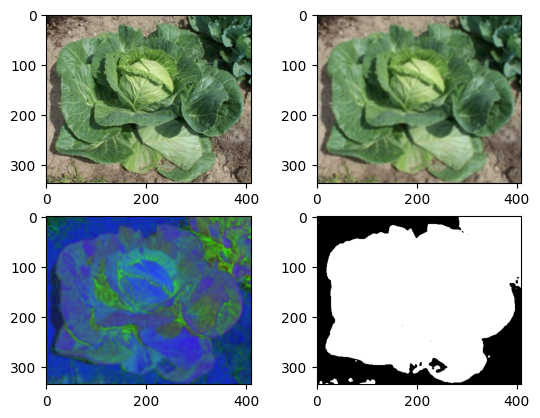

In [28]:
print(' (1,1):img1_rgb \n (1,2):blur_rgb \n (2,1):img_hsv \n (2,2):mask')
plt.subplot(2,2,1), plt.imshow(img1_rgb)
plt.subplot(2,2,2), plt.imshow(blur_rgb)
plt.subplot(2,2,3), plt.imshow(img1_hsv)
plt.subplot(2,2,4), plt.imshow(mask,'gray')

###### Thx to 'alkasm' for his answer on stackoverflow.com

Some noise present in the final image shown below, can be removed by using morphological operators- MORPH_OPEN and MORPH_CLOSE

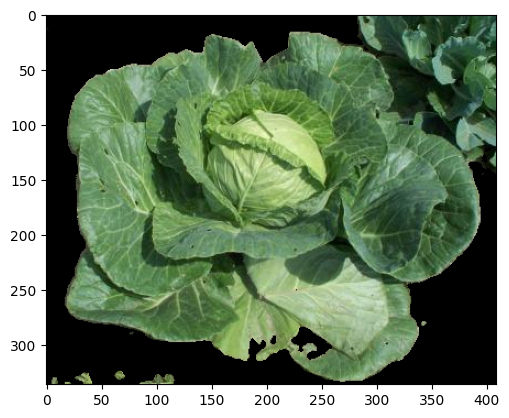

In [29]:
img1_masked_rgb = cv.cvtColor(src=img1_masked_bgr,code=cv.COLOR_BGR2RGB)
plt.imshow(img1_masked_rgb)

----

### GRAYSCALE IMAGES

- Thresholding can be used for distinguishing foreground from background. By selecting an optimal threshold value for image intensity, all pixel intensities below threshold are set to 'black' and all above this to 'white' or left at orignal intensity (THRESH_BINARY/THRESH_TOZERO). 

- Suppose the image histogram is divided into foreground and background class. The between class variance obtained by calculating mean and variance of each class the histogram is divided into, is maximised so that the classes (two or more) are as distinct as possible. This distinction is  even useful for object detection.

- Also it can be shown mathematically maximising between class variance is equivalent to minimising within class variance. As calculations of between class variance is computatuonally less expensive than within class variance it is prefered. It is also preferd to use histogram equilisation to increase image contrast, before applying threshold for better participation of all image intensities.

In [30]:
#Function gives optimal thresh output. Noboyuki Otsu's method is
#A nonparametric and unsupervised method of automatic threshold 
#selection for picture segmentation.

def thresh_otsu_val (image, mask):
    '''Uses Otsu's Method to obtain optimal thresh value, but with added mask
    INPUTS: image is 3 or less channel, mask is array of {dim[:2] of image}
    OUTPUT: optimal threshold value(int/float)'''

    hist= cv.calcHist([image],[0],mask, [256],[0,256],accumulate=False)

    hist_norm = hist.ravel()/hist.sum() #hist_norm is the probability of each of the 256 intensities
    Q = hist_norm.cumsum()
    bins = np.arange(256)

    fn_min = np.inf
    thresh = -1
    

    for i in range(1,256):
        p1,p2 = np.hsplit(hist_norm, [i]) # probabilities
        q1, q2 = Q[i], Q[255] - Q[i] # cummulative sum of classes
        if q1 < 1.e-6 or q2 < 1.e-6:
           continue

        b1, b2 = np.hsplit(bins,[i]) # weights

        #finding means and variances
        m1 ,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1,v2 = np.sum(((b1-m1)**2)*p1)/q1, np.sum(((b2-m2)**2)*p2)/q2

        #calculates the minimisation function
        fn = v1*q1 + v2*q2
        if fn < fn_min:
            fn_min = fn
            thresh = i
    # if param is True:
    #     print('type: {}\n shape: {}\n head:\n {} '.format(type(hist),hist.shape,hist[:5]))
    #     plt.plot(hist, color = 'b')
    #     plt.title('function thresh_otsu_val')
    #     plt.show()
    return thresh

In [31]:
def display_img(img,title):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, title=title)
    ax.imshow(img,'gray')

In [32]:
img = cv.imread('/Users/anantgokhale/images/00006585_007.png', 0)
equalise_img = cv.equalizeHist(img)
blur_img = cv.GaussianBlur(equalise_img, (5,5),0)

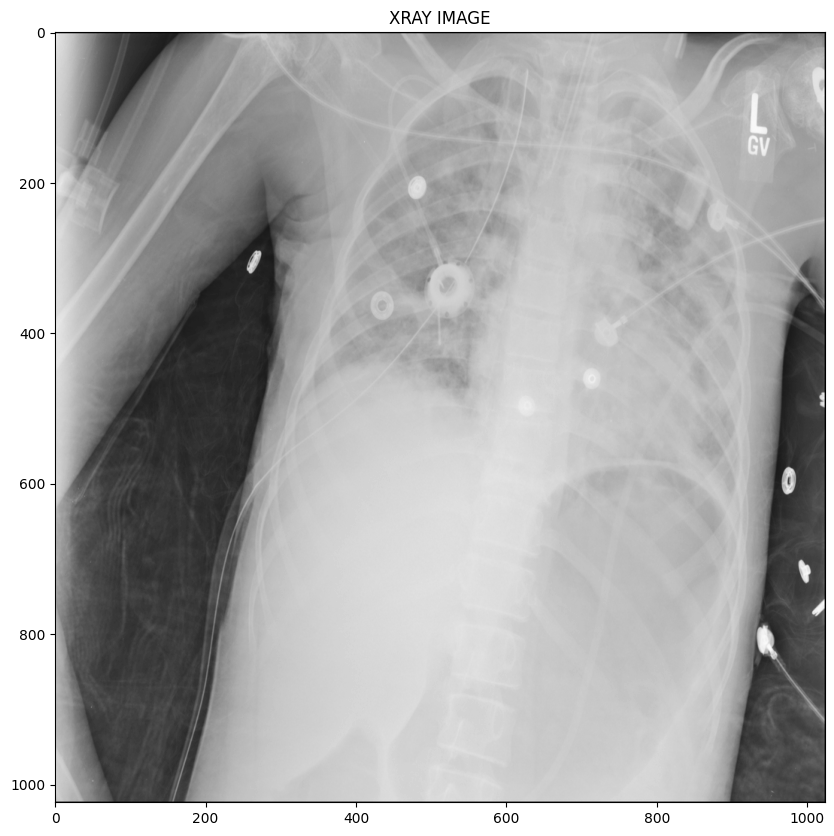

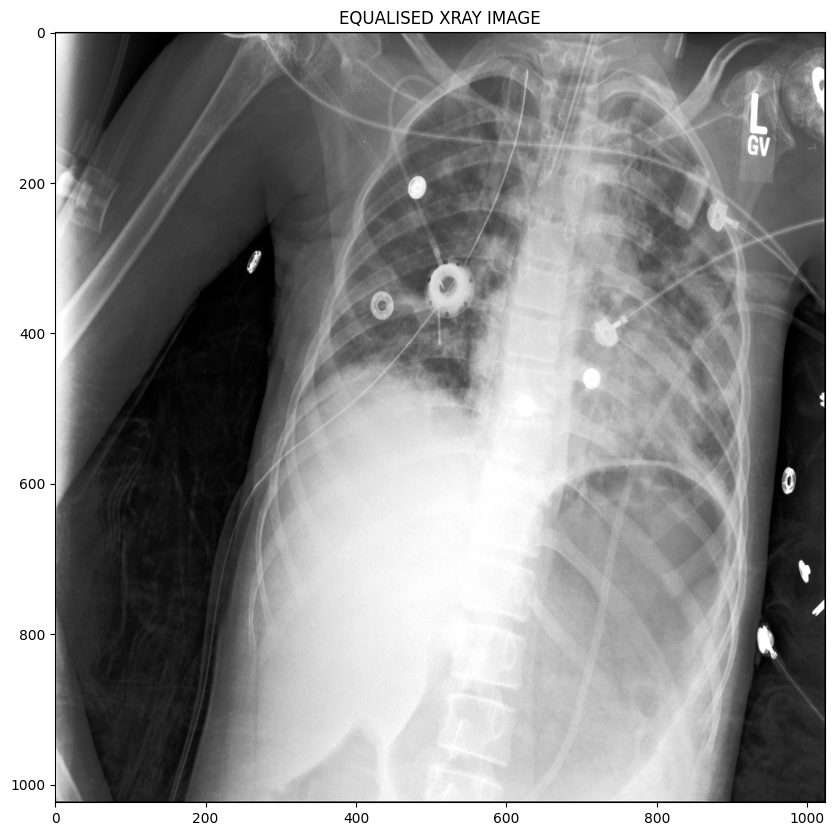

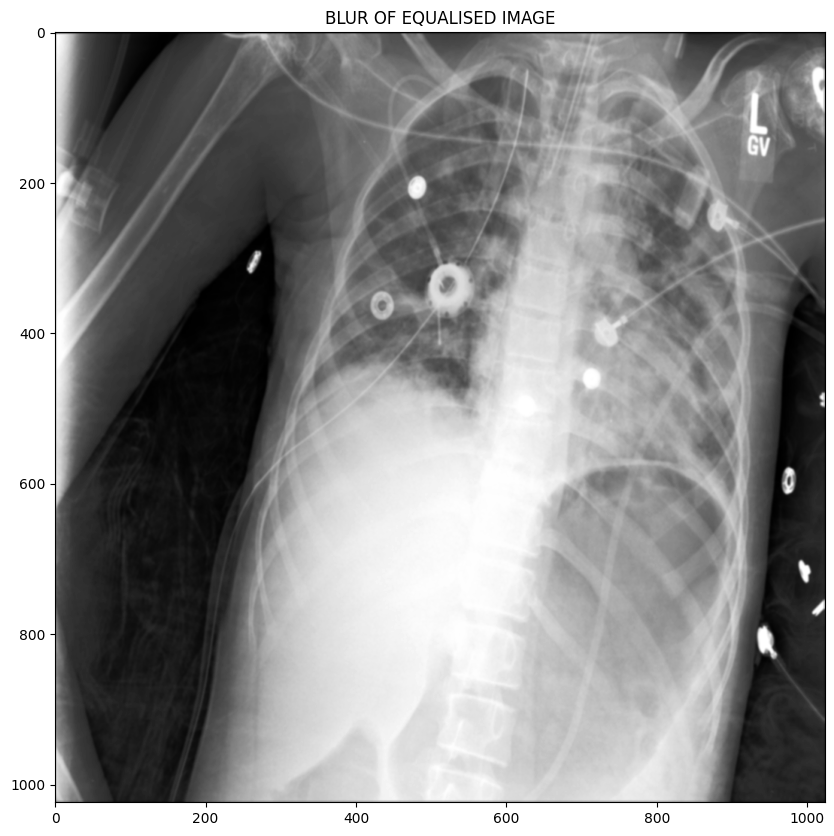

In [33]:
display_img(img,'XRAY IMAGE')
display_img(equalise_img, 'EQUALISED XRAY IMAGE')
display_img(blur_img,'BLUR OF EQUALISED IMAGE')

In [34]:
mask = cv.inRange(src=equalise_img, lowerb=40, upperb=255)
blur_mask = cv.inRange(src=blur_img, lowerb=40, upperb= 255)

th1_val = thresh_otsu_val(equalise_img,mask)
th2_val = thresh_otsu_val(blur_img,blur_mask)

print(' The Threshold values are: \n th1_val\t{} \n th2_val\t{}'.format(th1_val,th2_val))

 The Threshold values are: 
 th1_val	147 
 th2_val	148


(<AxesSubplot: title={'center': 'Gaussian Blur Mask'}>,
 <matplotlib.image.AxesImage at 0x14e3822b0>)

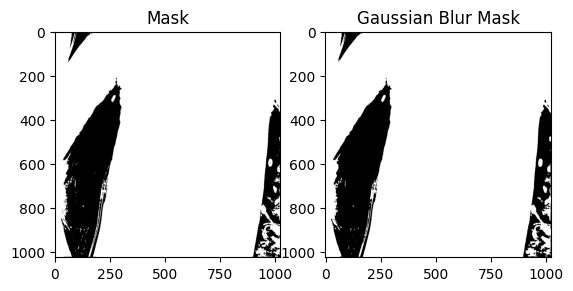

In [35]:
plt.subplot(1,2,1, title='Mask'), plt.imshow(mask, 'gray')
plt.subplot(1,2,2, title='Gaussian Blur Mask'), plt.imshow(blur_mask, 'gray')

The mask removes the effect of low intensity pixels during creation of foreground and background classes while computing th1_val and th2_val.

In [36]:
ret1,thresh1 = cv.threshold(src=equalise_img,thresh=th1_val,maxval=255,type=cv.THRESH_TOZERO)
ret2,thresh2 = cv.threshold(src=blur_img,thresh=th2_val,maxval=255,type=cv.THRESH_TOZERO)

 (1,1)thresh1
 (1,2)thresh2


(<AxesSubplot: title={'center': 'Eq+blur+blur_mask+otsu+tozero'}>,
 <matplotlib.image.AxesImage at 0x14e56b640>)

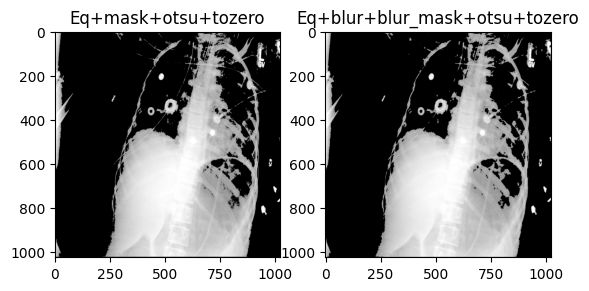

In [37]:
print(' (1,1)thresh1\n (1,2)thresh2')
plt.subplot(1,2,1, title='Eq+mask+otsu+tozero'), plt.imshow(thresh1,'gray')
plt.subplot(1,2,2, title = 'Eq+blur+blur_mask+otsu+tozero'), plt.imshow(thresh2, 'gray')

The white patch in lower right lobe is clearly visible. The folowing image 00006585_007.png is from NIH Xray dataset. The diseased person suffers from Atelectasis

In [38]:
canny1 = cv.Canny(thresh1,125,175)
canny2 = cv.Canny(thresh2,125,175)

(<AxesSubplot: title={'center': 'Canny2'}>,
 <matplotlib.image.AxesImage at 0x14e31c5b0>)

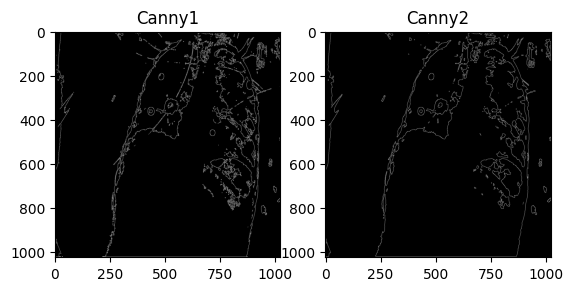

In [39]:
plt.subplot(1,2,1, title='Canny1'), plt.imshow(canny1, 'gray')
plt.subplot(1,2,2, title='Canny2'), plt.imshow(canny2, 'gray')